In [66]:
from setproctitle import setproctitle
setproctitle("LFFF")

In [67]:
k = 1
a = 0.5
B0 = 1
L = 1

Nx = 128
Ny = 128
Nz = 128

In [68]:
import numpy as np

x = np.linspace(-np.pi/(2*k), np.pi/(2*k), Nx)
y = np.linspace(-L/2, L/2, Ny)
z = np.linspace(0, 10, Nz)

dx = np.diff(x)[0]
dy = np.diff(y)[0]
dz = np.diff(z)[0]

x, y, z = np.meshgrid(x, y, z, indexing='ij')

In [69]:
Bx = -B0*(np.sqrt(k**2 - a**2)/k)*np.cos(k*x)*np.exp(-np.sqrt(k**2-a**2)*z)
By = -B0*(a/k)*np.cos(k*x)*np.exp(-np.sqrt(k**2-a**2)*z)
Bz = B0*np.sin(k*x)*np.exp(-np.sqrt(k**2-a**2)*z)

B = np.stack([Bx, By, Bz], axis=-1)

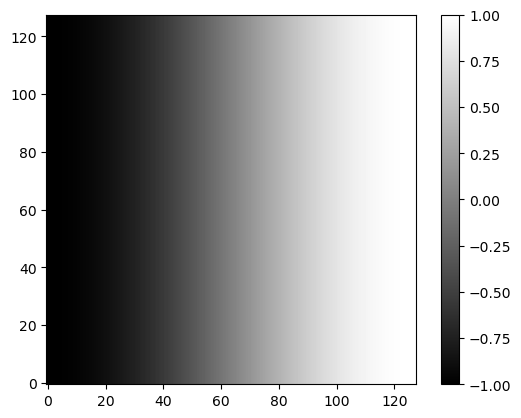

In [70]:
import matplotlib.pyplot as plt

plt.imshow(Bz[:, :, 0].transpose(), origin='lower', cmap='gray')
plt.colorbar()

In [71]:
import pyvista as pv
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

In [72]:
mesh = pv.StructuredGrid(x, y, z)
vector = B.transpose(2, 1, 0, 3).reshape(-1, 3)
magnitude = np.linalg.norm(vector, axis=-1)
mesh['B'] = vector
mesh['magnitude'] = magnitude
mesh.active_vectors_name = 'B'
mesh.active_scalars_name = 'magnitude'

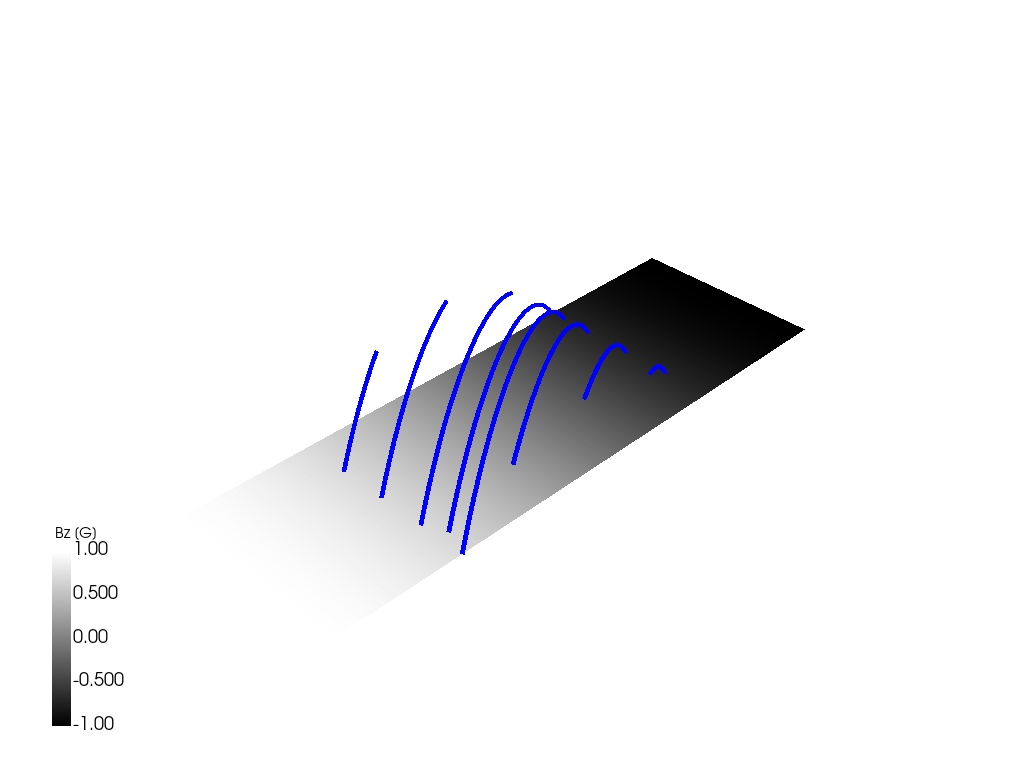

In [73]:
p = pv.Plotter()
# p.show_bounds()
# p.add_mesh(mesh.outline())

seed = pv.Plane(center=(mesh.center[0], mesh.center[1], 0), direction=(0, 0, 1),
                i_size=mesh.bounds[1]-mesh.bounds[0], j_size=mesh.bounds[3]-mesh.bounds[2], 
                i_resolution=4, j_resolution=4)
# p.add_mesh(seed)

strl = mesh.streamlines_from_source(seed, vectors='B',
                                    max_time=180, initial_step_length=0.1, integration_direction='both')
p.add_mesh(strl.tube(radius=0.01), 
           lighting=False, color='blue')

x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
Nx, Ny, Nz = mesh.dimensions
x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1
bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
bottom = mesh.extract_subset(bottom_subset).extract_surface()
bottom.active_vectors_name = 'B'
bottom.active_scalars_name = 'magnitude'

vmin = -1
vmax = 1
sargs_B = dict(
    title='Bz [G]',
    title_font_size=15,
    height=0.25,
    width=0.05,
    vertical=True,
    position_x = 0.05,
    position_y = 0.05,
)
dargs_B = dict(
    scalars='B', 
    component=2, 
    clim=(vmin, vmax), 
    scalar_bar_args=sargs_B, 
    show_scalar_bar=True, 
    lighting=False
)
p.add_mesh(bottom, cmap='gray', **dargs_B)

p.show()

In [74]:
def magnitude(vector):
    return np.sqrt((vector**2).sum(-1))

def gradient(scalar, dx=None, dy=None, dz=None):

    if (dx is not None) and (dy is not None) and (dz is not None):
        Dx_scalar, Dy_scalar, Dz_scalar = np.gradient(scalar, dx, dy, dz, axis=[0, 1, 2], edge_order=2)
    else:
        Dx_scalar, Dy_scalar, Dz_scalar = np.gradient(scalar, axis=[0, 1, 2], edge_order=2)

    return np.stack([Dx_scalar, Dy_scalar, Dz_scalar], axis=-1)
    
def divergence(vector, dx=None, dy=None, dz=None):
    vector_x, vector_y, vector_z = vector[..., 0], vector[..., 1], vector[..., 2]

    if (dx is not None) and (dy is not None) and (dz is not None):
        Dx_vector_x = np.gradient(vector_x, dx, axis=[0], edge_order=2)
        Dy_vector_y = np.gradient(vector_y, dy, axis=[1], edge_order=2)
        Dz_vector_z = np.gradient(vector_z, dz, axis=[2], edge_order=2)
    else:
        Dx_vector_x = np.gradient(vector_x, axis=[0], edge_order=2)
        Dy_vector_y = np.gradient(vector_y, axis=[1], edge_order=2)
        Dz_vector_z = np.gradient(vector_z, axis=[2], edge_order=2)

    return Dx_vector_x + Dy_vector_y + Dz_vector_z

def curl(vector, dx=None, dy=None, dz=None):
    vector_x, vector_y, vector_z = vector[..., 0], vector[..., 1], vector[..., 2]

    if (dx is not None) and (dy is not None) and (dz is not None):
        Dy_vector_x, Dz_vector_x = np.gradient(vector_x, dy, dz, axis=[1, 2], edge_order=2)
        Dx_vector_y, Dz_vector_y = np.gradient(vector_y, dx, dz, axis=[0, 2], edge_order=2)
        Dx_vector_z, Dy_vector_z = np.gradient(vector_z, dx, dy, axis=[0, 1], edge_order=2)
    else:
        Dy_vector_x, Dz_vector_x = np.gradient(vector_x, axis=[1, 2], edge_order=2)
        Dx_vector_y, Dz_vector_y = np.gradient(vector_y, axis=[0, 2], edge_order=2)
        Dx_vector_z, Dy_vector_z = np.gradient(vector_z, axis=[0, 1], edge_order=2)
    
    curl_x = Dy_vector_z - Dz_vector_y 
    curl_y = Dz_vector_x - Dx_vector_z
    curl_z = Dx_vector_y - Dy_vector_x

    return np.stack([curl_x, curl_y, curl_z], axis=-1)

def laplacian(scalar, dx=None, dy=None, dz=None):
    if (dx is not None) and (dy is not None) and (dz is not None):
        gradient_scalar = gradient(scalar, dx, dy, dz)
        Dx_scalar = gradient_scalar[..., 0]
        Dy_scalar = gradient_scalar[..., 1]
        Dz_scalar = gradient_scalar[..., 2]

        Dx_Dx_scalar = np.gradient(Dx_scalar, dx, axis=[0], edge_order=2)
        Dy_Dy_scalar = np.gradient(Dy_scalar, dy, axis=[1], edge_order=2)
        Dz_Dz_scalar = np.gradient(Dz_scalar, dz, axis=[2], edge_order=2)
    else:
        gradient_scalar = gradient(scalar)
        Dx_scalar = gradient_scalar[..., 0]
        Dy_scalar = gradient_scalar[..., 1]
        Dz_scalar = gradient_scalar[..., 2]

        Dx_Dx_scalar = np.gradient(Dx_scalar, axis=[0], edge_order=2)
        Dy_Dy_scalar = np.gradient(Dy_scalar, axis=[1], edge_order=2)
        Dz_Dz_scalar = np.gradient(Dz_scalar, axis=[2], edge_order=2)

    return Dx_Dx_scalar + Dy_Dy_scalar + Dz_Dz_scalar

def laplacian_vector(vector, dx=None, dy=None, dz=None):
    vector_x, vector_y, vector_z = vector[..., 0], vector[..., 1], vector[..., 2]

    if (dx is not None) and (dy is not None) and (dz is not None):
        laplacian_vector_x = laplacian(vector_x, dx, dy, dz)
        laplacian_vector_y = laplacian(vector_y, dx, dy, dz)
        laplacian_vector_z = laplacian(vector_z, dx, dy, dz)
    else:
        laplacian_vector_x = laplacian(vector_x)
        laplacian_vector_y = laplacian(vector_y)
        laplacian_vector_z = laplacian(vector_z)

    return np.stack([laplacian_vector_x, laplacian_vector_y, laplacian_vector_z], axis=-1)

def magnetic_energy(magnetic_field_vector):
    return (magnetic_field_vector**2).sum(-1) / (8*np.pi)

In [75]:
B_field = mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

In [76]:
J = curl(B_field, dx=dx, dy=dy, dz=dz)

In [77]:
# alpha
(magnitude(J) / magnitude(B_field)).mean()

0.4999516925394884

In [78]:
# JxB
magnitude(np.cross(J, B, -1)).mean()

3.151675065964716e-05

In [79]:
# divB
np.abs(divergence(B_field, dx=dx, dy=dy, dz=dz)).mean()

5.9276231270715204e-05

In [80]:
dV = dx*dy*dz

In [81]:
magnetic_energy(B_field).sum() * dV

0.07842243262816279

In [82]:
(np.pi*L*(B0**2)) / (16*np.pi*k*np.sqrt(k**2-a**2))

0.07216878364870323